# Training neural networks

In this tutorial, we are going to explore how we can train an artificial neural networks with backpropagation. Crucially, this allows us to train networks with _multiple layers_. In the first part, you will have to derive expressions to update the weights of the network across layers, and in the second part we will experiment with a modern neural network to classify handwritten digits.

## Introduction

In tutorial 2, we showed how a single neuron cannot compute the XOR function (or any nonlinear function for that matter), but how the problem can be solved if we harvest the computational power of a network of neurons. In assignment 3, we went on to see how we could develop an algorithm that allows us to train the parameter of a single neuron, and we concluded by presenting another version of a nonlinear problem that cannot be solved by a linear decision boundary (the red and green 'moons'). In this introduction, we start off with the same moons dataset and show how a two layer network can learn the nonlinear relation in the data.

In the cell below, we train a neural network with two layers on the moon dataset from tutorial 3. If you run it, two plots will appear. On the left is a plot of just the dataset (we only generate a few more samples this time). On the right, we plot the data again, and we show the decision boundary by shading the areas of input space that the network classifies as the 'green' class and as the 'red' class. 

Test loss: 0.00042124587344005704
Test accuracy: 1.0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


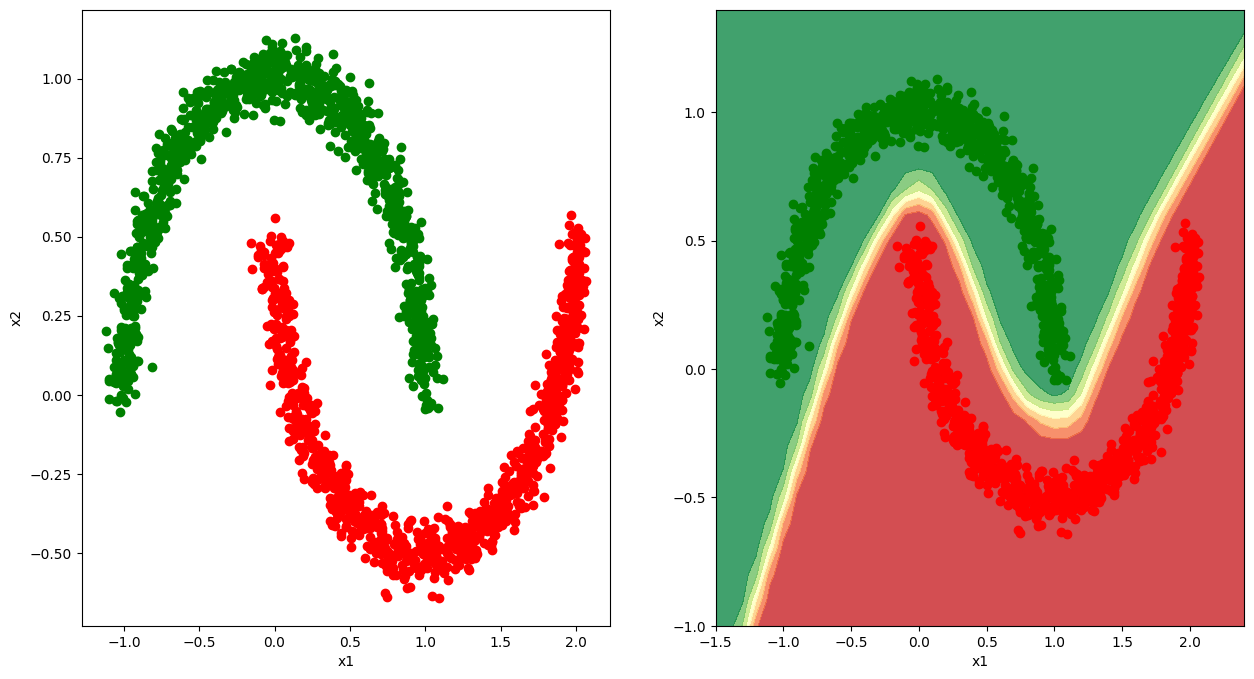

In [4]:
import warnings
warnings.filterwarnings('ignore')  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop


X, y = make_moons(n_samples=4000, shuffle=True, noise=0.05)
split = 2000
x_train, y_train = X[:split], y[:split]
x_test, y_test   = X[split:], y[split:]

batch_size = 100
num_classes = 2
n_units = [100, 100]
n_epochs = 30

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train
x_test 

y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()

model.add(Dense(n_units[0], activation='relu', input_shape=(2,)))

if len(n_units) > 1:
    for nu in n_units[1:]:
        model.add(Dense(nu, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train_onehot,
                    batch_size=batch_size,
                    epochs=n_epochs,
                    verbose=0,
                    validation_data=(x_train, y_train_onehot))

score = model.evaluate(x_test, y_test_onehot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# plotting
x_min, x_max, y_min, y_max = -1.5, 2.5, -1, 1.5
h = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

plot_pred = model.predict(np.c_[xx.ravel(), yy.ravel()])[:, 0]
Z = plot_pred.reshape(xx.shape)

f, ax = plt.subplots(1, 2, figsize=[15, 8])
ax[0].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], color='g')
ax[0].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], color='r')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')

ax[1].contourf(xx, yy, Z, cmap='RdYlGn', alpha=.8)
ax[1].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], color='g')
ax[1].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], color='r')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
plt.show()

As you see, the network can generate a nonlinear decision boundary that carves out the shape of the moons, so as to correctly classify the data! You may notice a somewhat graded transition between green and red: that is because our network is really giving us a _probability_ that a sample belongs to a certain class, and it is up to us to turn that probability into a decision. We will come back to a cool application of neural networks in part 2, but now let's dig deeper into how backpropagation actually works. 

## Part 1 - Understanding backpropagation

We begin with the simplest possible 'deep' neural network, composed of a single-unit hidden layer and one output layer. This network is not going to be useful for anything, but it will allow us to illustrate how we can perform backpropagation on deep (i.e. more than one layer) architectures. 

![title](images/bp_1.svg)

Importantly, a neural network can be seen as a chain of computation. We begin with our input $x$, then at every layer we compute the weighted sum of the input, pass it through a nonlinearity $f$ (the transfer function) and compute the output. The output of the final layer, together with the target output, will allow us to compute a loss. We can then use this loss to update our parameters using backpropagation. For this tutorial, we will use

\begin{align}
L &= \frac{1}{2}(\hat{y} - y)^2 \\
f(x) &= \sigma(x) = \frac{1}{1+e^{-x}}
\end{align}

We will also not explicitly worry about the bias, to keep things a little bit simpler, so consider $b_1 =b_2 =0$.

### Question 1
Write the output $\hat{y}$ as a function of $x$, $w_1$, and $w_2$. You don't have to fill in the sigmoid function, write the transfer function simply as $f$.

### Answer 1
[your answer]

### Question 2
Suppose that 
\begin{align}
x &= 1.5 \\
w_1 &= 0.5 \\
w_2 &= 0.3 \\
\end{align}

Use the equation you derived to compute the output $\hat{y}$.

### Answer 2
[your answer]

We have seen how our network produces output given some input. This is referred to as a _forward pass_, where we go from input to output. Now, supposing we have compared our output with a target value, and know the loss, we can to 'propagate' this loss backward to update the parameters (most importantly the weights) which generated the output. This is the crux of backpropagation.  

### Question 3

Derive an expression for $\frac{\partial L}{\partial w_2}$.

_Hint:_ Expand the derivative using the __chain rule__ as you saw in the lecture! You should arrive to this formula: $(\hat{y} - y) \sigma(w_2 z_1)(1- \sigma(w_2 z_1)) z_1$ (to arrive at it, you will have to fill in the sigmoid function $\sigma(x)$, compute its derivative, and write that derivative as a function of $\sigma(x)$).

### Answer 3
[your answer]

### Question 4
Derive an expression for $\frac{\partial L}{\partial w_1}$.

_Hint:_ This is going to be just a longer chain rule expansion!

### Answer 4
[your answer]

Chances are computing these derivatives was a little confusing, so let's not lose track of the point that we are trying to make here:

- Our neural network is essentially a series of chained computations. At every layer, we compute something based on the input we received and feed it to the next layer.
- We only know the loss at the very end of the chain: we know what the output neurons should output, but no one is telling us what the hidden layers should be doing.
- With a smart use of the chain rule, we can figure out how we should change the parameters _at every step in the chain_ such that we get a lower loss. 

### Question 5
Suppose $w_2$ = 0.3, we have a learning rate $\alpha=0.1$, and we computed $\frac{\partial L}{\partial w_2}$ = 0.8. Update $w_2$ using gradient descent. 

### Answer 5
[your answer]

## Part 2 - Neural networks in action

 The networks we have seen so far were nothing more than toy examples, created to illustrate some important features of neural networks, and they don't really do anything cool. But our brain is capable of incredibly complex computations, and so are (with some limitations, of course) artificial neural networks. In fact, the successes of artificial intelligence (which often means really fancy neural networks) are everywhere on the media. Having stacked layers like the one in our example, where one layer feeds into the next ('deep' architectures) and being able to train the parameters with backpropagation, are at the origin of the success of artificial intelligence. 

In this second part, we are going to train an artificial neural network on a classic task, namely classifying images of handwritten digits (the famous 'MNIST' dataset). Although this is not even close to showing the full potential of modern state of the art networks, it should give you an idea that we can use the principles illustrated here to do some actually cool stuff. Let's take a look at the data! Run the cell below to plot some random images from our training set.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


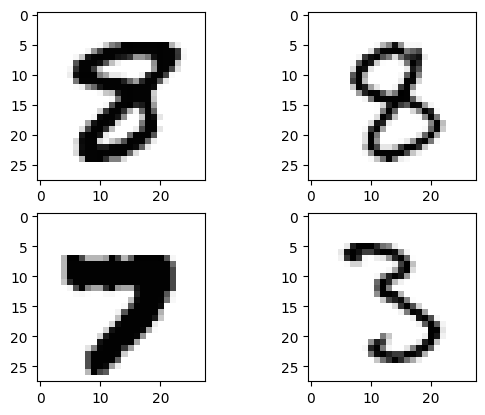

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

f, axes = plt.subplots(2, 2)
for ax in axes.flatten():
    ind = np.random.choice(x_train.shape[0])
    ax.imshow(x_train[ind], cmap='Greys')
plt.show()

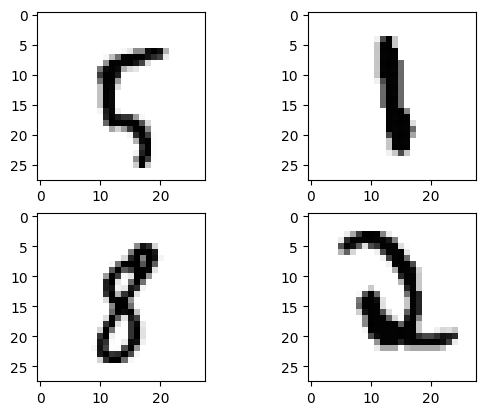

In [6]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
f, axes = plt.subplots(2, 2)
indices = [100, 200, 300, 400]
for ax, ind in zip(axes.flatten(), indices):
    ax.imshow(x_train[ind], cmap='Greys')
plt.show()

For every image in our dataset, we have an associated label telling us what digit the image corresponds to. We are going to train the network to recognize these images. Every image is 28 by 28 pixels (784 pixels in total). We will split our dataset into a part that we will use to train the network, and leave out some data to _test_ how well the network can classify digits that it hasn't seen before.

To construct the network, we will use a popular high-level library called Keras, which allows us to define and train and architecture with a few lines of code. Modern neural network libraries rely on _automatic differentiation_, which means that all the gradients (like the ones we computed in the first part) are actually computed for us, so that we don't have to worry about it. The example we will use is adapted from the Keras documentation.

When we instantiate the simulation, three widgets will pop up, which will allows you to specify
- the number of hidden layers in the model
- the number of units per layer
- the number of training epochs

An epoch is essentially a round of training on all images in the dataset. Usually, we need several epochs to get a good accuracy on a dataset (our network needs to 'see' the data a few times to properly learn it). 

### Question 1
We are going to start by making a network with one hidden layer with 15 units. So our input, which is 784 pixels, is going to be passed through a hidden layer of size 15, which is then connected to an output unit of size 10 (one neuron per digit in the output layer). Do you think this network is going to be able to learn how to classify digits well? Why/why not?

### Answer 1
[your answer]

### Question 2
Run the cell below, which will set up the simulation. Edit the settings to have one hidden layer with 15 units and training for 10 epochs, then press 'Initialize and train'. 

Once training is finished, read and try to understand the output of the training. The metric that we are most interested in is the __validation accuracy__, which measures how many images in the test set we were able to classify correctly (number of correctly classified divided by number of images in the test set - with accuracy of 1 our network can classify perfectly).

How does the achieved accuracy compare to your expectations?

In [1]:
from utils_assignment_4 import ffnn_simulation
simulation = ffnn_simulation()
simulation.start()

2025-08-18 13:09:14.900867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


BoundedIntText(value=1, description='Number of layers:', max=10, min=1)

BoundedIntText(value=100, description='# units per layer:', max=1000, min=1)

BoundedIntText(value=20, description='# epochs:', min=1)

Button(description='Initialize and train', style=ButtonStyle())

### Answer 2
[your answer]

### Question 3
Let us now run a simulation again, this time let's use two layers with 50 neurons each, and train for 10 epochs. Inspect your results, and compare them with the previous experiment.

In [ ]:
simulation = ffnn_simulation()
simulation.start()

### Answer 3
[your answer]

### Question 4

The output of the simulation says `Train on 60000 samples, validate on 10000 samples`, meaning that the network was trained using 60000 samples, whereas the evaluation of the accuracy was performed using a separate set of 10000 samples. Why would you want to use separate subsets of data to train and evaluate your network?

### Answer 4
[your answer]

### Question 5

Similarly to the last question, you can see in the output that the classification accuracy on the training set tends to be higher than the test accuracy, especially during the later training epochs. The scenario where accuracy on the training set is perfect, but the accuracy on the test data is very poor, is called overfitting. What factors in the network architecture and training procedure do you think can contribute to overfitting?

### Answer 5
[your answer]

### Question 6
Now, take some time to freely experiment with the number of units, the number of layers, and the number of training epochs. Try different parameter configurations to try and maximize accuracy. Then, elaborate on your results. In particular address the following points:

- With which parameters did you achieve the highest accuracy?
- Is adding more neurons per layer always beneficial? Why/why not?
- Is adding more layers always beneficial? Why/why not?
- Is training for more epochs always beneficial? Why/why not?
- What is the downside of having more neurons/layers?

To play around, you can either use the `initialize and train` button, or you can also create a new cell, then type the following two lines to instantiate a new simulation:

`simulation = ffnn_simulation()
simulation.start()`

In [ ]:
simulation = ffnn_simulation()
simulation.start()

### Answer 6
[your answer]